<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classification-VIT/Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models


Load Preprocessed dataset

In [ ]:
# Define the dataset directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Dataset_classification"


EDA

In [ ]:
# Exploratory Data Analysis (EDA)
def perform_eda(images, labels, class_names):
    """Perform EDA on the dataset."""
    import pandas as pd

    # 1. Dataset Overview
    print("\n--- Dataset Overview ---")
    print(f"Total Images: {len(images)}")
    print(f"Total Classes: {len(class_names)}")
    print(f"Class Distribution: {np.bincount(labels)}")
    print("\nClass Names with Distribution:")
    class_distribution = pd.DataFrame({"Class": class_names, "Count": np.bincount(labels)})
    print(class_distribution)

    # 2. Visualize Class Distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_distribution['Class'], y=class_distribution['Count'], palette="viridis")
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

    # 3. Display Sample Images from Each Class
    print("\n--- Displaying Sample Images from Each Class ---")
    plt.figure(figsize=(16, 10))
    for i, class_name in enumerate(class_names):
        idx = labels.tolist().index(i)  # Get the first image index for this class
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 4. Image Shape and Value Distribution
    print("\n--- Image Shape and Value Distribution ---")
    print(f"Image Shape: {images[0].shape}")
    print(f"Pixel Intensity Range: Min = {np.min(images)}, Max = {np.max(images)}")
    plt.figure(figsize=(12, 5))
    plt.hist(images.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

    # 5. Check for Class Imbalance
    print("\n--- Checking Class Imbalance ---")
    class_imbalance = np.bincount(labels)
    max_samples = max(class_imbalance)
    imbalance_ratio = max_samples / class_imbalance
    print(f"Imbalance Ratio: {imbalance_ratio}")
    if any(imbalance_ratio > 1.5):
        print("Warning: Dataset has class imbalance.")


Function to load dataset

In [ ]:
def load_dataset(base_dir):
    """Load the dataset, preprocess images, and return data and labels."""
    images, labels = [], []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    print(f"Class Names: {class_names}")

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, file)
                try:
                    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"[ERROR] Could not process {file_path}: {e}")
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32), class_names # Return class_names



Split the dataset

In [ ]:
# Load and split the dataset
images, labels, class_names = load_dataset(base_dir) # Assign class_names
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

print (f"Training Images Shape: {train_images.shape}")
print (f"Training Labels Shape: {train_labels.shape}")


Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']
Training Images Shape: (22400, 224, 224, 1)
Training Labels Shape: (22400,)


Visualize EDA


--- Dataset Overview ---
Total Images: 32000
Total Classes: 16
Class Distribution: [2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000]

Class Names with Distribution:
                Class  Count
0         Astrocitoma   2000
1           Carcinoma   2000
2          Ependimoma   2000
3       Ganglioglioma   2000
4           Germinoma   2000
5        Glioblastoma   2000
6           Granuloma   2000
7      Meduloblastoma   2000
8         Neurocitoma   2000
9   Oligodendroglioma   2000
10           Papiloma   2000
11         Schwannoma   2000
12        Tuberculoma   2000
13         meningioma   2000
14          no tumour   2000
15          pituitary   2000


<ipython-input-23-935a15dbbfb1>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution['Class'], y=class_distribution['Count'], palette="viridis")


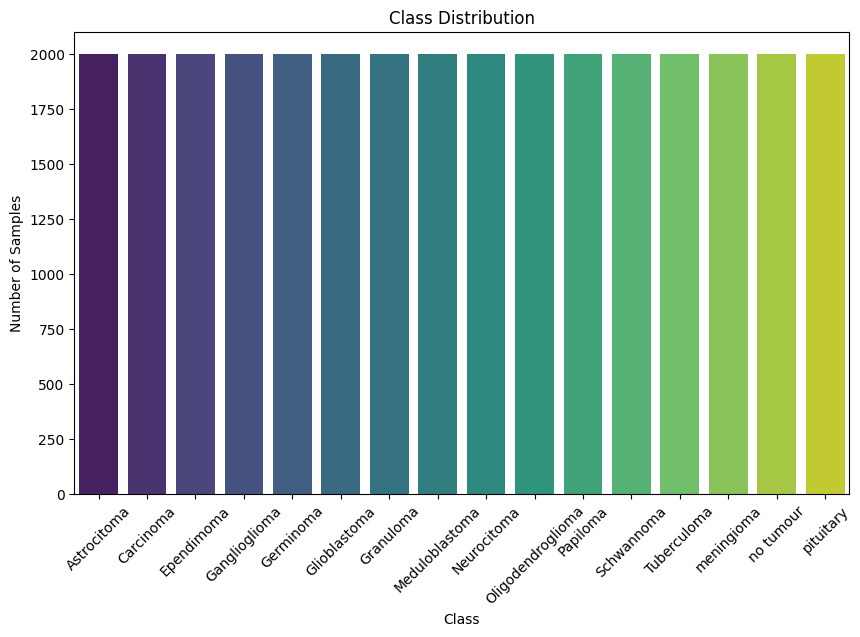


--- Displaying Sample Images from Each Class ---


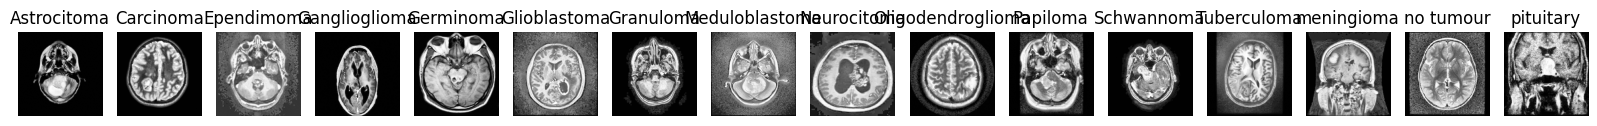


--- Image Shape and Value Distribution ---
Image Shape: (224, 224, 1)
Pixel Intensity Range: Min = 0.0, Max = 1.0


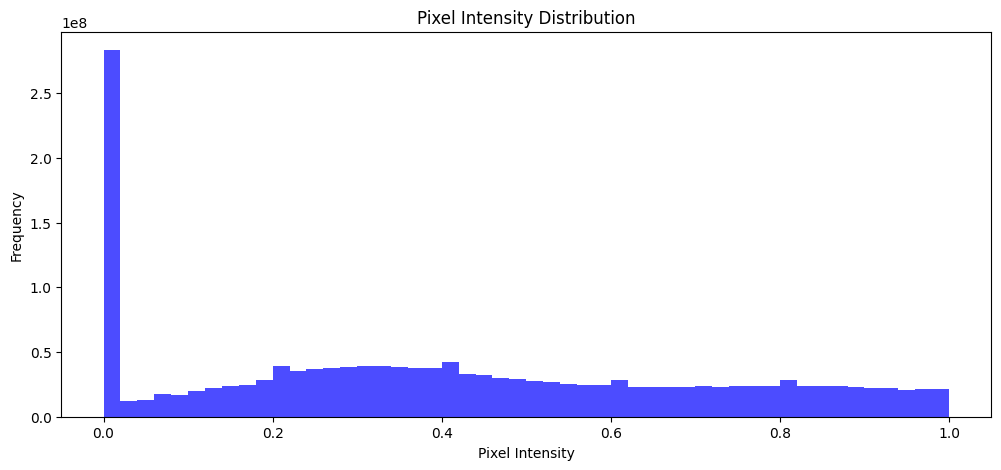


--- Checking Class Imbalance ---
Imbalance Ratio: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Perform EDA on the dataset
perform_eda(images, labels, class_names)

Create the Vision Transformer model

In [ ]:
def create_vit_model(input_shape, num_classes):
    """Build a Vision Transformer model for image classification."""
    inputs = tf.keras.Input(shape=input_shape)

    # Patch Embedding
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Conv2D(64, patch_size, strides=patch_size)(inputs)
    x = layers.Reshape((num_patches, -1))(x)

    # Positional Embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=64)(positions)
    x += positional_embedding

    # Transformer Layers
    for _ in range(4):  # 4 Transformer blocks
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization()(x)

        ff_output = layers.Dense(128, activation='relu')(x)
        ff_output = layers.Dense(64)(ff_output)
        x = layers.Add()([x, ff_output])
        x = layers.LayerNormalization()(x)

    # Classification Head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)



In [ ]:
# Create the model
input_shape = (224, 224, 1)
num_classes = len(np.unique(labels))
model = create_vit_model(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         16,448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 196, 64)        │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 196, 64)        │              0 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_8    │ (None, 196, 64)        │         66,368 │ add_17[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_17[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 196, 64)        │              0 │ add_17[0][0],          │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 196, 64)        │            128 │ add_18[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 196, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 196, 64)        │          8,256 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 196, 64)        │              0 │ layer_normalization_1… │
│                           │                        │                │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_17    │ (None, 196, 64)        │            128 │ add_19[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_9    │ (None, 196, 64)        │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 196, 64)        │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_18    │ (None, 196, 64)        │            128 │ add_20[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 196, 128)       │          8,320 │ layer_normalization_1… │
├──────────────────────

 Total params: 350,288 (1.34 MB)

 Trainable params: 350,288 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the model

In [ ]:
# Train the model
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=70, batch_size=32)

Epoch 1/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 449s 627ms/step - accuracy: 0.1196 - loss: 2.6743 - val_accuracy: 0.2093 - val_loss: 2.4629
Epoch 2/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 427s 611ms/step - accuracy: 0.2551 - loss: 2.2469 - val_accuracy: 0.4062 - val_loss: 1.7709
Epoch 3/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 427s 610ms/step - accuracy: 0.4491 - loss: 1.6950 - val_accuracy: 0.5711 - val_loss: 1.2854
Epoch 4/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 439s 627ms/step - accuracy: 0.6007 - loss: 1.2310 - val_accuracy: 0.6859 - val_loss: 0.9532
Epoch 5/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 438s 626ms/step - accuracy: 0.7099 - loss: 0.8898 - val_accuracy: 0.7487 - val_loss: 0.7541
Epoch 6/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 434s 620ms/step - accuracy: 0.7776 - loss: 0.6734 - val_accuracy: 0.8067 - val_loss: 0.6139
Epoch 7/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 424s 606ms/step - accuracy: 0.8196 - loss: 0.5512 - val_accuracy: 0.8119 - val_loss: 0.5900
Epoch 8/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 435s 622ms/step - accuracy: 0.8382 -

Save the model

In [ ]:
#Save the model
model.save("/content/drive/MyDrive/DSGP_BrainTumorDetection/Tumor_Classisfication_ViT_Model.keras")


Evaluate the model performance

In [ ]:
# Evaluate the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 243ms/step


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       600
           1       0.98      0.98      0.98       600
           2       0.98      0.96      0.97       600
           3       1.00      0.97      0.99       600
           4       0.99      0.99      0.99       600
           5       0.97      1.00      0.98       600
           6       1.00      0.94      0.97       600
           7       0.99      0.99      0.99       600
           8       0.92      0.96      0.94       600
           9       0.95      0.99      0.97       600
          10       0.98      0.98      0.98       600
          11       0.90      0.96      0.93       600
          12       0.99      1.00      1.00       600
          13       0.96      0.86      0.91       600
          14       0.94      0.90      0.92       600
          15       0.91      0.97      0.94       600

    accuracy                           0.96      9600
   

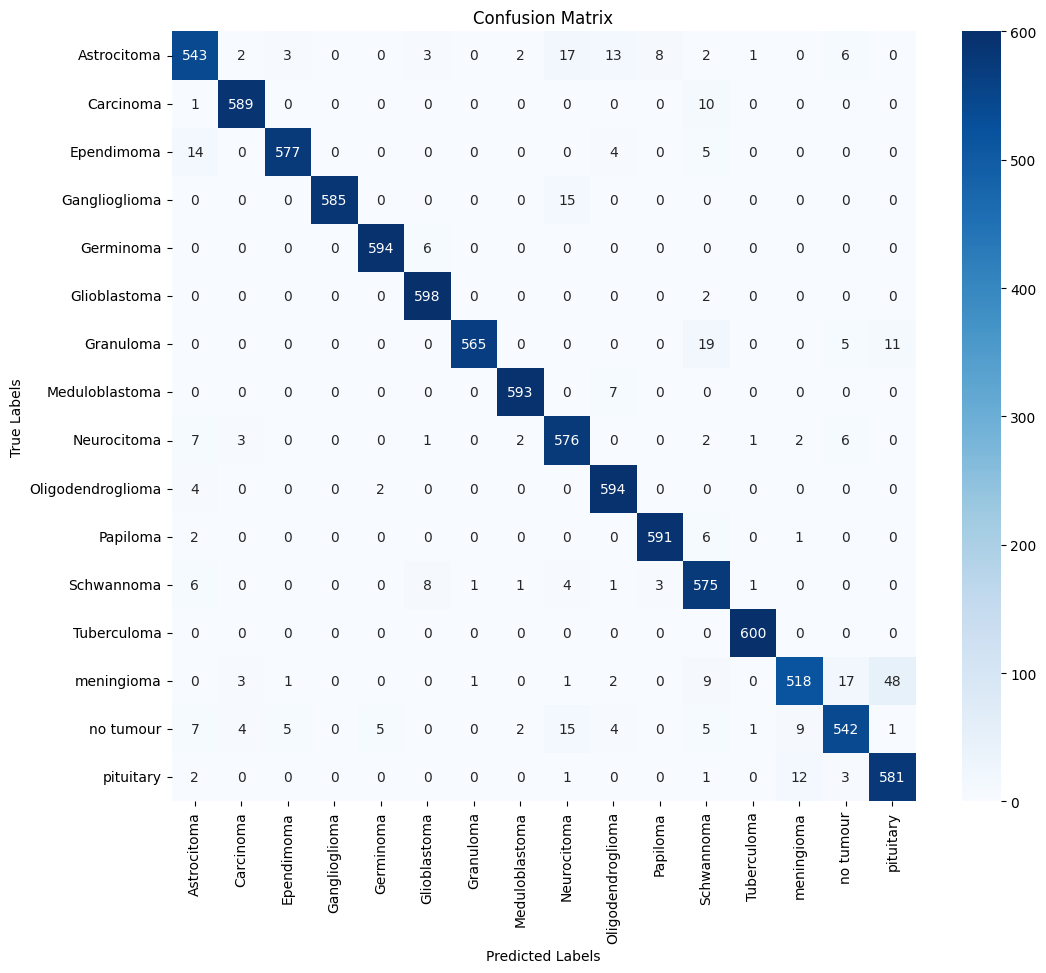

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


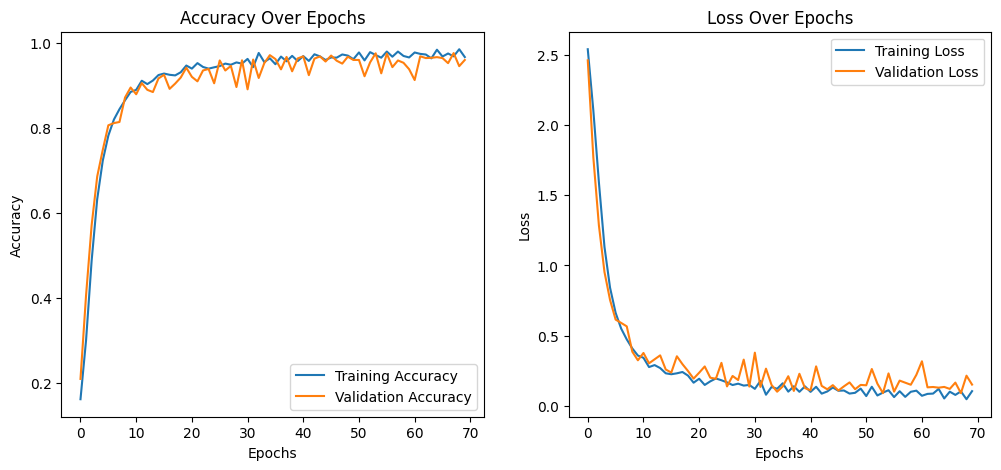

In [ ]:
# Plot Training and Validation Metrics
def plot_metrics(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 5))

    # Accuracy
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)